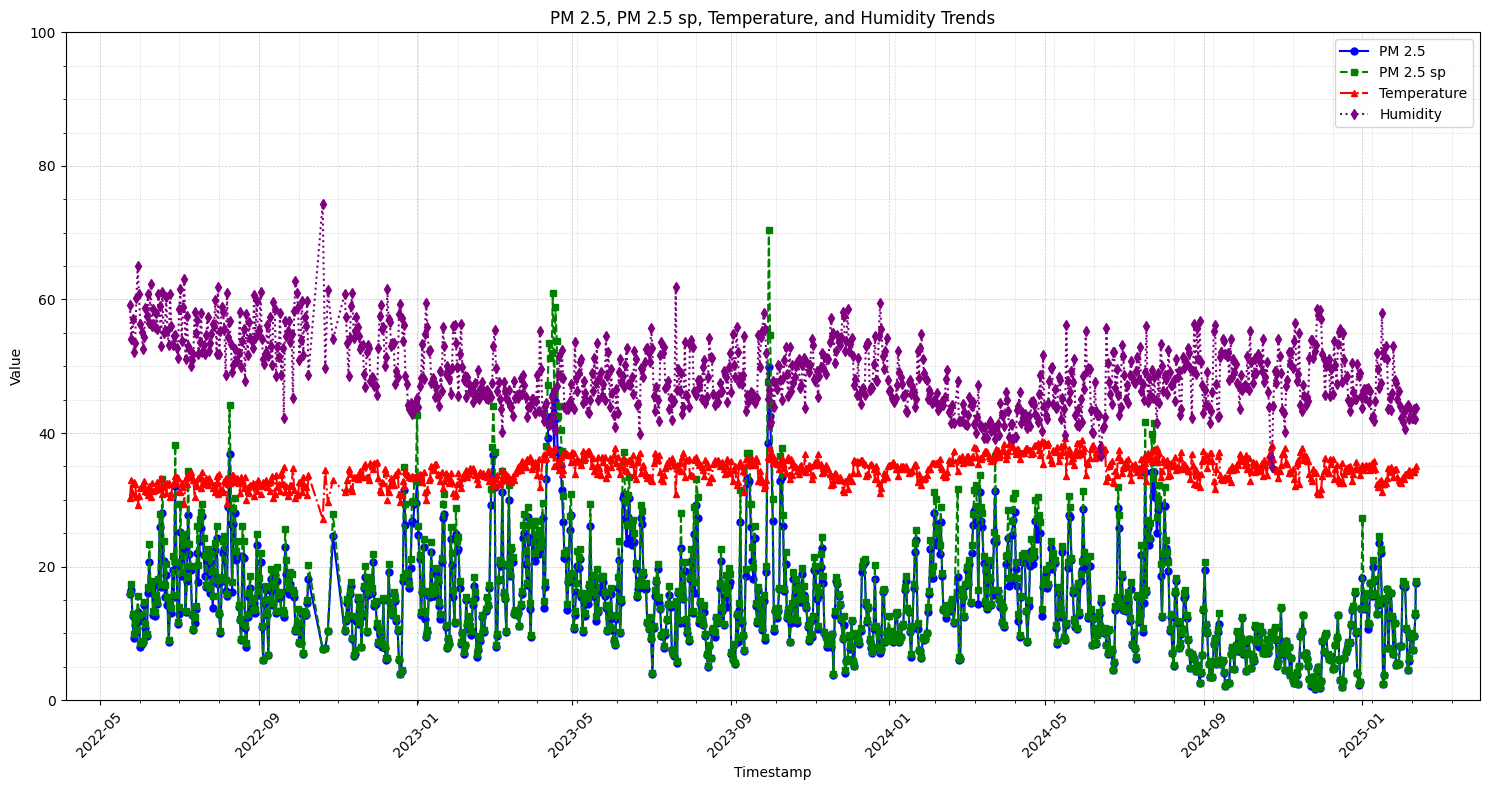

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# อ่านไฟล์ CSV
df = pd.read_csv("VL_pm_data.csv")

# แปลงคอลัมน์ timestamp เป็น datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# สร้างกราฟเส้น (Line Plot) ของ pm_2_5, pm_2_5_sp, temperature และ humidity
plt.figure(figsize=(15, 8))  # กำหนดขนาดกราฟ

# Plot PM 2.5
plt.plot(df['timestamp'], df['pm_2_5'], marker='o', markersize=5, linestyle='-', color='blue', label='PM 2.5')
plt.plot(df['timestamp'], df['pm_2_5_sp'], marker='s', markersize=5, linestyle='--', color='green', label='PM 2.5 sp')

# Plot Temperature
plt.plot(df['timestamp'], df['temperature'], marker='^', markersize=5, linestyle='-.', color='red', label='Temperature')

# Plot Humidity
plt.plot(df['timestamp'], df['humidity'], marker='d', markersize=5, linestyle=':', color='purple', label='Humidity')

# ตั้งค่าชื่อแกนและชื่อกราฟ
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("PM 2.5, PM 2.5 sp, Temperature, and Humidity Trends")

# ตั้งค่าขอบเขตของแกน y ให้แสดงค่าตั้งแต่ 0 ถึง 100
plt.ylim(0, 100)

# แสดงเส้นตารางและคำอธิบายเส้นกราฟ
plt.grid(True, linestyle='--', alpha=0.7)

# เพิ่มเส้นตารางในแกน x และ y
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.legend()

# แสดงกราฟ
plt.xticks(rotation=45)  # หมุนแกน x เพื่อให้อ่านง่ายขึ้น
plt.tight_layout()  # ปรับ layout ให้พอดีกับพื้นที่
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12296\3574541630.py:19: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")  # เติมค่าที่หายไปด้วย Interpolation


✅ ทำความสะอาดข้อมูลเสร็จเรียบร้อย พร้อมใช้กับ AI!


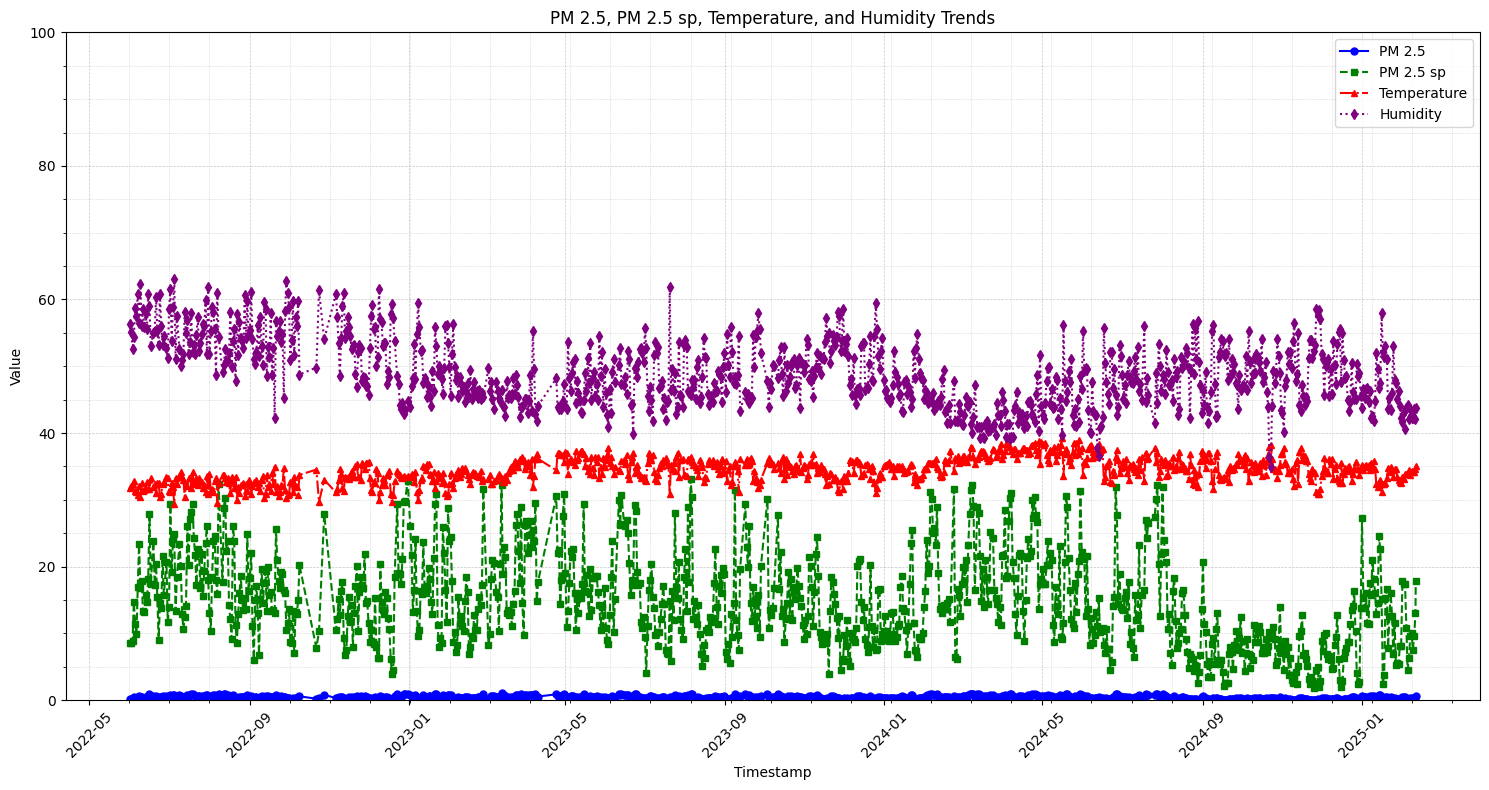

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 📌 โหลดข้อมูล
df = pd.read_csv("VL_pm_data.csv", parse_dates=["timestamp"])

# 📌 แปลง dtype ของคอลัมน์ให้เป็น numeric
df = df.infer_objects(copy=False)

# แปลงคอลัมน์ที่เป็นตัวเลขให้เป็น float
for col in ["pm_2_5", "pm_2_5_sp", "temperature", "humidity"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")  # ถ้าแปลงไม่ได้ให้เป็น NaN

# 📌 เติมค่าที่หายไป
df = df.infer_objects(copy=False)  # แปลง dtype ของคอลัมน์ให้เป็น numeric ก่อน interpolate
df = df.interpolate(method="linear")  # เติมค่าที่หายไปด้วย Interpolation
df = df.bfill()  # ใช้ backward fill (bfill) เผื่อมี NaN ที่เติมไม่ครบ

# 📌 ตรวจสอบ Outliers ด้วย IQR + Z-score
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    z_scores = np.abs(zscore(df[column]))
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound) & (z_scores < 3)]
    return df_cleaned

for col in ["pm_2_5", "pm_2_5_sp", "temperature", "humidity"]:
    df = remove_outliers(df, col)

# 📌 สร้าง Features จาก Timestamp
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["weekday"] = df["timestamp"].dt.weekday
df["hour"] = df["timestamp"].dt.hour

# 📌 สร้าง Lag Features (ค่า PM2.5 ของวันก่อนหน้า)
df["pm_2_5_lag1"] = df["pm_2_5"].shift(1)   # ค่าของวันก่อนหน้า
df["pm_2_5_lag7"] = df["pm_2_5"].shift(7)   # ค่าของ 7 วันก่อนหน้า (1 สัปดาห์)
df = df.dropna()  # ลบแถวที่มีค่า NaN หลังจากสร้าง Lag Features

# 📌 ใช้ Rolling Mean ลด Noise (ค่าเฉลี่ยเคลื่อนที่ 3 วัน)
df["pm_2_5_smooth"] = df["pm_2_5"].rolling(window=3).mean()
df["pm_2_5_smooth"] = df["pm_2_5_smooth"].bfill()  # เติมค่าที่หายไป

# 📌 ทำ Scaling ให้ค่าตัวเลขอยู่ในช่วง 0-1 เพื่อให้โมเดล AI เทรนได้ดีขึ้น
scaler = MinMaxScaler()
df[["pm_2_5", "pm_2_5_lag1", "pm_2_5_lag7", "pm_2_5_smooth"]] = scaler.fit_transform(
    df[["pm_2_5", "pm_2_5_lag1", "pm_2_5_lag7", "pm_2_5_smooth"]]
)

# 📌 บันทึกข้อมูลที่ทำความสะอาดแล้ว
df.to_csv("clean_pm25_data.csv", index=False)

print("✅ ทำความสะอาดข้อมูลเสร็จเรียบร้อย พร้อมใช้กับ AI!")

# สร้างกราฟเส้น (Line Plot) ของ pm_2_5, pm_2_5_sp, temperature และ humidity
plt.figure(figsize=(15, 8))  # กำหนดขนาดกราฟ

# Plot PM 2.5
plt.plot(df['timestamp'], df['pm_2_5'], marker='o', markersize=5, linestyle='-', color='blue', label='PM 2.5')
plt.plot(df['timestamp'], df['pm_2_5_sp'], marker='s', markersize=5, linestyle='--', color='green', label='PM 2.5 sp')

# Plot Temperature
plt.plot(df['timestamp'], df['temperature'], marker='^', markersize=5, linestyle='-.', color='red', label='Temperature')

# Plot Humidity
plt.plot(df['timestamp'], df['humidity'], marker='d', markersize=5, linestyle=':', color='purple', label='Humidity')

# ตั้งค่าชื่อแกนและชื่อกราฟ
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("PM 2.5, PM 2.5 sp, Temperature, and Humidity Trends")

# ตั้งค่าขอบเขตของแกน y ให้แสดงค่าตั้งแต่ 0 ถึง 100
plt.ylim(0, 100)

# แสดงเส้นตารางและคำอธิบายเส้นกราฟ
plt.grid(True, linestyle='--', alpha=0.7)

# เพิ่มเส้นตารางในแกน x และ y
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

plt.legend()

# แสดงกราฟ
plt.xticks(rotation=45)  # หมุนแกน x เพื่อให้อ่านง่ายขึ้น
plt.tight_layout()  # ปรับ layout ให้พอดีกับพื้นที่
plt.show()
